In [27]:
import os
import pathlib
import shapely.geometry
import geopandas
import shutil
import numpy
import xarray
import rioxarray
import json
import pdal

# Define data paths

In [20]:
data_dir = pathlib.Path(os.getcwd()) / pathlib.Path('data')
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
catchment_name = 'catchment_boundary'
catchment_dir = data_dir / pathlib.Path(catchment_name)
land_name = 'land'
land_dir = data_dir / pathlib.Path(land_name)
bathymetry_name = 'bathymetry'
bathymetry_dir = data_dir / pathlib.Path(bathymetry_name)
dem_dir = data_dir / pathlib.Path('reference_dem.nc')
lidar_dir = data_dir / pathlib.Path('lidar.laz')

In [3]:
crs = 2193

# Create catchment and land boundary

In [4]:
x0 = 250; y0 = -250; x1 = 1250; y1 = 750;
catchment = shapely.geometry.Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
catchment = geopandas.GeoSeries([catchment])
catchment.to_file(catchment_dir)
shutil.make_archive(base_name=catchment_dir, format='zip', root_dir=data_dir, base_dir=catchment_name)
shutil.rmtree(catchment_dir)

In [5]:
x0 = 0; y0 = 0; x1 = 1500; y1 = 1000;
land = shapely.geometry.Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
land = geopandas.GeoSeries([land])
land.set_crs(crs)
catchment.to_file(land_dir)
shutil.make_archive(base_name=land_dir, format='zip', root_dir=data_dir, base_dir=land_name)
shutil.rmtree(land_dir)

# Create bathymetry

In [6]:
x0 = 0; x1 = 1500; y0 = -50; y1 = -100; y2 = -200;
contour_0 = shapely.geometry.LineString([(x0, y0), (x1, y0)])
contour_1 = shapely.geometry.LineString([(x0, y1), (x1, y1)])
contour_2 = shapely.geometry.LineString([(x0, y2), (x1, y2)])
contours = geopandas.GeoSeries([contour_0, contour_1, contour_2])
contours.set_crs(crs)
contours.to_file(bathymetry_dir)
shutil.make_archive(base_name=bathymetry_dir, format='zip', root_dir=data_dir, base_dir=bathymetry_name)
shutil.rmtree(bathymetry_dir)

# Create DEM

In [7]:
dxy = 15
grid_dem_x, grid_dem_y = numpy.meshgrid(numpy.arange(200, 1300, dxy), numpy.arange(-25, 800, dxy))
grid_dem_z = numpy.zeros_like(grid_dem_x, dtype = numpy.float64)
grid_dem_z[grid_dem_y < 0] = grid_dem_y[grid_dem_y < 0] / 10
grid_dem_z[grid_dem_y > 0] = grid_dem_y[grid_dem_y > 0 ] / 10 * (numpy.abs(grid_dem_x[grid_dem_y > 0 ] - 750) / 500 + 0.1) / 1.1
dem = xarray.DataArray(grid_dem_z, coords = {'x': grid_dem_x[0], 'y': grid_dem_y[:,0]}, dims = ['y','x'], 
                       attrs={'scale_factor': 1.0, 'add_offset': 0.0})
dem.rio.set_crs(crs)
dem.to_netcdf(dem_dir)

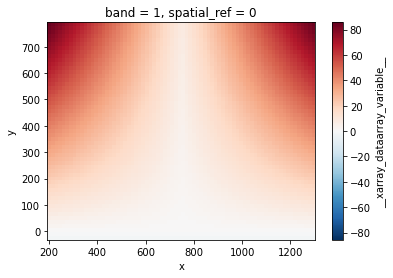

In [8]:
dem_in=rioxarray.rioxarray.open_rasterio(dem_dir, masked=True, parse_coordinates=True)
dem_in.plot()

# Create LiDAR - work in progress

In [10]:
dxy = 1
grid_lidar_x, grid_lidar_y = numpy.meshgrid(numpy.arange(500, 1000, dxy), numpy.arange(-25, 475, dxy))
grid_lidar_z = numpy.zeros_like(grid_lidar_x, dtype = numpy.float64)
grid_lidar_z[grid_lidar_y < 0] = grid_lidar_y[grid_lidar_y < 0] / 10
grid_lidar_z[grid_lidar_y > 0] = grid_lidar_y[grid_lidar_y > 0 ] / 10 * (numpy.abs(grid_lidar_x[grid_lidar_y > 0 ] - 750) 
                                                                   / 500 + 0.1) / 1.1
lidar_array = numpy.empty([len(grid_lidar_x.flatten())], dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')])
lidar_array['X'] = grid_lidar_x.flatten()
lidar_array['Y'] = grid_lidar_y.flatten()
lidar_array['Z'] = grid_lidar_z.flatten()

pdal_pipeline_instructions = [
    {"type":  "writers.las", "a_srs": "EPSG:" + str(crs),"filename": str(lidar_dir), "compression": "laszip"}
]

pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions), [lidar_array])
pdal_pipeline.execute();

# Run experiment - need to correctly configure package so it can be included

In [37]:
import GeoFabrics

ImportError: attempted relative import with no known parent package

# View generated data

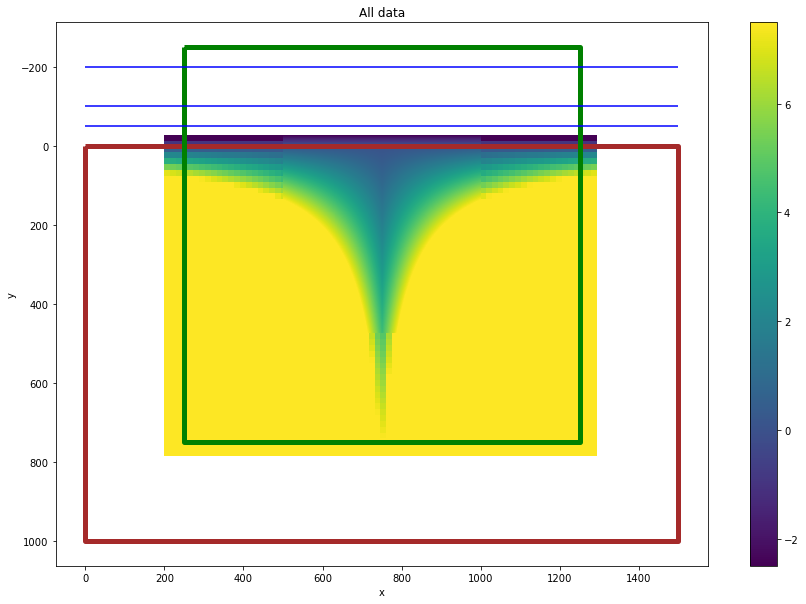

In [19]:
import matplotlib.pyplot
f, ax = matplotlib.pyplot.subplots(figsize=(15, 10))
vmin = -2.5; vmax = 7.5;

p = matplotlib.pyplot.imshow(grid_dem_z, extent=[grid_dem_x.min(), grid_dem_x.max(), grid_dem_y.max(), grid_dem_y.min()], 
                             vmin=vmin, vmax = vmax)
p2 = matplotlib.pyplot.imshow(grid_lidar_z, extent=[grid_lidar_x.min(), grid_lidar_x.max(), grid_lidar_y.max(), 
                                                    grid_lidar_y.min()], vmin=vmin, vmax = vmax)
land.plot(ax=ax, color='None', edgecolor='brown', linewidth=5)
catchment.plot(ax=ax, color='None', edgecolor='green', linewidth=5)
contours.plot(ax=ax, marker='o', color='blue', markersize=5)
matplotlib.pyplot.xlabel('x')
matplotlib.pyplot.ylabel('y')
ax.set_title("All data")
f.colorbar(p, ax=ax)